In [72]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from copy import copy

In [73]:
def load_image(path: str):
  img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
  return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [74]:
def plot_images(images: list):
  for image in images:
    figure = plt.figure(figsize=(16, 16))
    plt.imshow(image)
    plt.show()
    plt.close(figure)

In [75]:
def process_image(image, image_processors: list):
  for processor in image_processors:
    image = processor(image)

  return image

In [76]:
def process_image_and_plot_image_transformations(image, image_processors: list):
  image_transformations = [image]
  for processor in image_processors:
    image_transformations.append(processor(image_transformations[-1]))

  plot_images(image_transformations)

In [77]:
def get_background_mask(image):
  obtain_mask_pipeline = [
    lambda img: cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),
    lambda img: cv2.medianBlur(img, ksize=7),
    lambda img: cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1],
    lambda img: cv2.morphologyEx(img, cv2.MORPH_OPEN, np.ones((5, 5)))
  ]
  return process_image(image, obtain_mask_pipeline)

In [78]:
def get_outer_contours_by_mask(mask):
  contours, _ = cv2.findContours(copy(mask), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  return contours

In [79]:
def draw_contours(image, contours):
  image = copy(image)
  cv2.drawContours(image, contours, -1, (255, 0, 0), 25)
  return image

In [80]:
def get_mask_by_contour(image, contour):
  mask = np.zeros_like(image)
  cv2.fillPoly(mask, contour, (255, 255, 255))
  return mask

def get_paper_mask(image):
  background_mask = get_background_mask(image)
  contours = get_outer_contours_by_mask(background_mask)
  assert len(contours) == 1
  return get_mask_by_contour(image, contours)

In [81]:
def apply_mask(image, paper_mask):
  mask_boolean = paper_mask != (255, 255, 255)
  if image.ndim == 2:
    mask_channels = [mask_boolean[:, :, i] for i in (0, 1, 2)]
    mask_boolean = np.logical_or(*mask_channels)

  return np.where(mask_boolean, 0, image)

In [82]:
def crop_image_to_bbox(image, bbox, shape_to_crop):
    x_bb, y_bb, w_bb, h_bb = bbox

    # transform x, y, w, h to coordinates of middle points, and w/2, h/2
    x_bb, y_bb, w_bb, h_bb = x_bb + w_bb//2, y_bb + h_bb//2, w_bb//2, h_bb//2

    H_img, W_img, _ = image.shape

    # x, y, w, h are the characteristics of crop region
    w, h = shape_to_crop[1]//2, shape_to_crop[0]//2

    def get_crop_region_mid_coord_along_axis(w, x_bb, w_bb, W_img):
        if w_bb > w:
            return x_bb, w_bb

        # mid x must be in [x_min, x_max]
        x_min = max(x_bb+w_bb-w, w)
        x_max = min(W_img-w, x_bb-w_bb+w)

        if x_min <= x_bb <= x_max:
            return x_bb, w

        return (x_min, w) if x_bb < x_min else (x_max, w)

    # middle coordinates of crop region
    x, w = get_crop_region_mid_coord_along_axis(w, x_bb, w_bb, W_img)
    y, h = get_crop_region_mid_coord_along_axis(h, y_bb, h_bb, H_img)

    # transform coordinates back
    x_bb, y_bb, w_bb, h_bb = x_bb-w_bb, y_bb-h_bb, 2*w_bb, 2*h_bb
    x, y, w, h = x-w, y-h, 2*w, 2*h

    # calculate end coordinates of regions (crop and bbox)
    x_end, y_end, x_bb_end, y_bb_end = x+w, y+h, x_bb+w_bb, y_bb+h_bb

    # fit bbox to cropped region
    def get_bbox_coords_along_axis(all_coords):
        all_coords = sorted(all_coords)
        return all_coords[1], all_coords[2]

    x_bb, x_bb_end = get_bbox_coords_along_axis([x, x_bb, x_bb_end, x_end])
    y_bb, y_bb_end = get_bbox_coords_along_axis([y, y_bb, y_bb_end, y_end])

    # update bounding box relative to cropped region
    x_bb, y_bb, w_bb, h_bb = x_bb-x, y_bb-y, x_bb_end-x_bb, y_bb_end-y_bb

    img_res = image[y:y+h, x:x+w]
    if w > shape_to_crop[1] or h > shape_to_crop[0]:
        img_res = cv2.resize(img_res, (shape_to_crop[1], shape_to_crop[0]))

    return img_res, (x_bb, y_bb, w_bb, h_bb)

In [83]:
def get_crop_with_object(image, contours):
  assert len(contours) > 0
  contour = max(contours, key=lambda contour: cv2.contourArea(contour))

  bbox_object = cv2.boundingRect(contour)
  crop, _ = crop_image_to_bbox(image, bbox_object, (256, 256))
  return crop

In [84]:
def get_objects_mask(image, do_plot=True):
  paper_mask = get_paper_mask(image)

  background_mask = cv2.bitwise_not(paper_mask)
  background_mask = cv2.morphologyEx(background_mask, cv2.MORPH_DILATE, kernel=np.ones((30, 30)), borderType=cv2.BORDER_REFLECT)
  background_mask = cv2.bitwise_not(background_mask)

  image_paper_only = apply_mask(image, paper_mask)

  def laplacian_edge(img):
    ddepth = cv2.CV_16S
    kernel_size = 5
    dst = cv2.Laplacian(img, ddepth, ksize=kernel_size)
    abs_dst = cv2.convertScaleAbs(dst)
    return abs_dst

  process_with_laplacian = [
    lambda img: cv2.medianBlur(img, ksize=13),
    lambda img: cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),
    lambda img: laplacian_edge(img),
    lambda img: cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)[1],
    lambda mask: apply_mask(mask, background_mask),
    lambda mask: cv2.morphologyEx(mask, cv2.MORPH_DILATE, kernel=np.ones((4, 4)), borderType=cv2.BORDER_REFLECT),
    lambda mask: cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel=np.ones((40, 40))),
    lambda mask: get_crop_with_object(image_paper_only, get_outer_contours_by_mask(mask)),
    #lambda mask: draw_contours(image_paper_only, get_outer_contours_by_mask(mask))
  ]
  if do_plot:
    process_image_and_plot_image_transformations(image_paper_only, process_with_laplacian)
    return None

  return process_image(image_paper_only, process_with_laplacian)

In [85]:
#IMAGE_PATH = "../data/images/760_6271584_7x1plate_w_holes.png"
#IMAGE_PATH = "../data/images/483_300224_3x2brick.png"
#IMAGE_PATH = "../examples/not_fit/8_not it.png"
#IMAGE_PATH = "../examples/fit/23_fit.png"
#IMAGE_PATH = "../data/images/564_6329156_4x4smooth_plate.png"
#IMAGE_PATH = "../data/images/652_6130009_rod.png"
IMAGE_PATH = "../data/images/371_6056830_wing_small.png"
#IMAGE_PATH = "../data/images/9_6323476_wing_big.png"

In [86]:
def test_image(image_path):
  image = load_image(image_path)
  get_objects_mask(image)

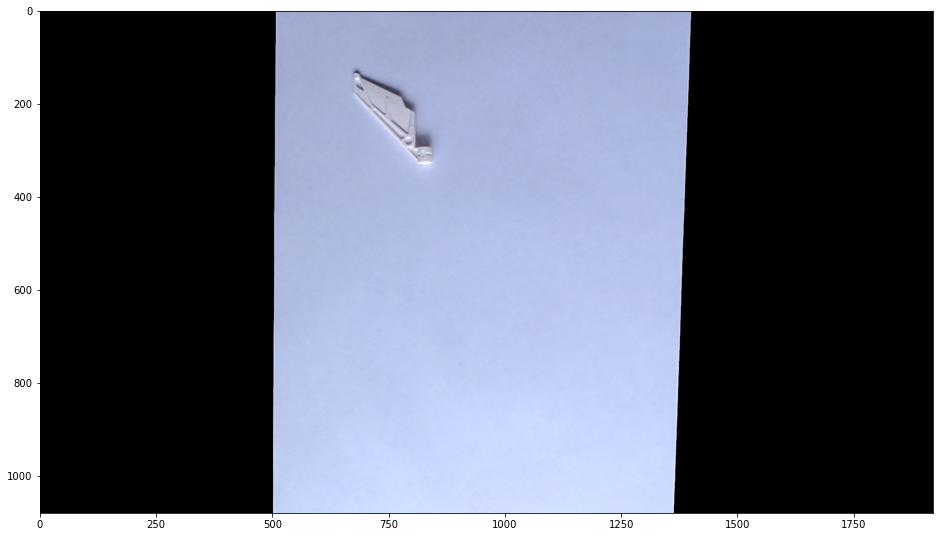

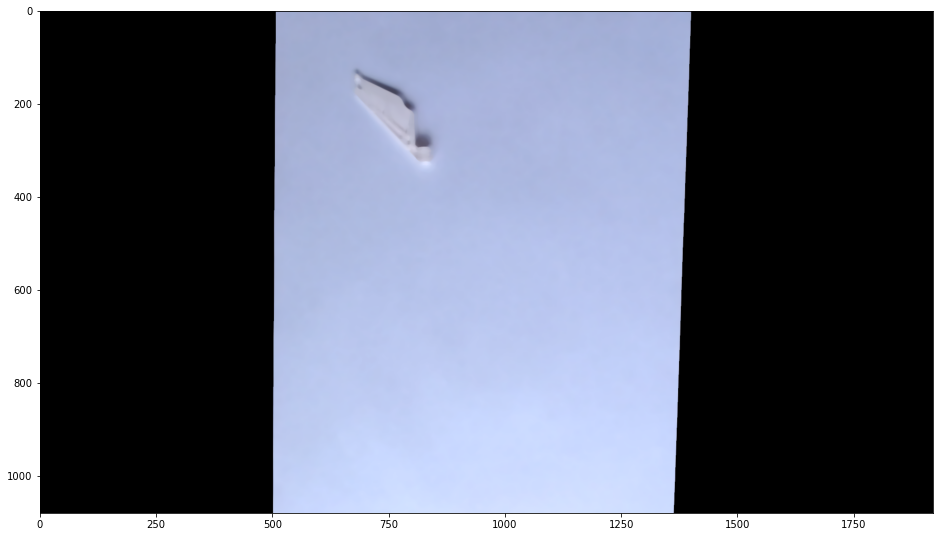

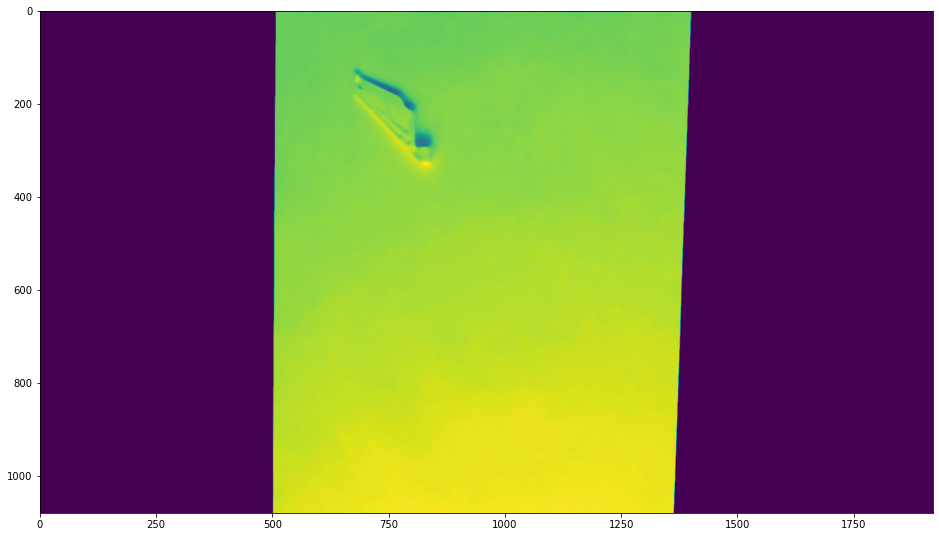

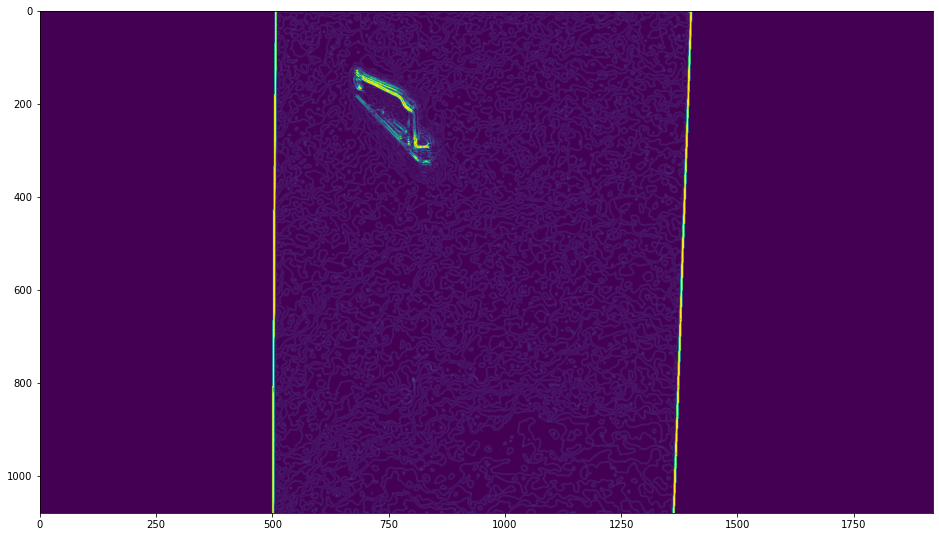

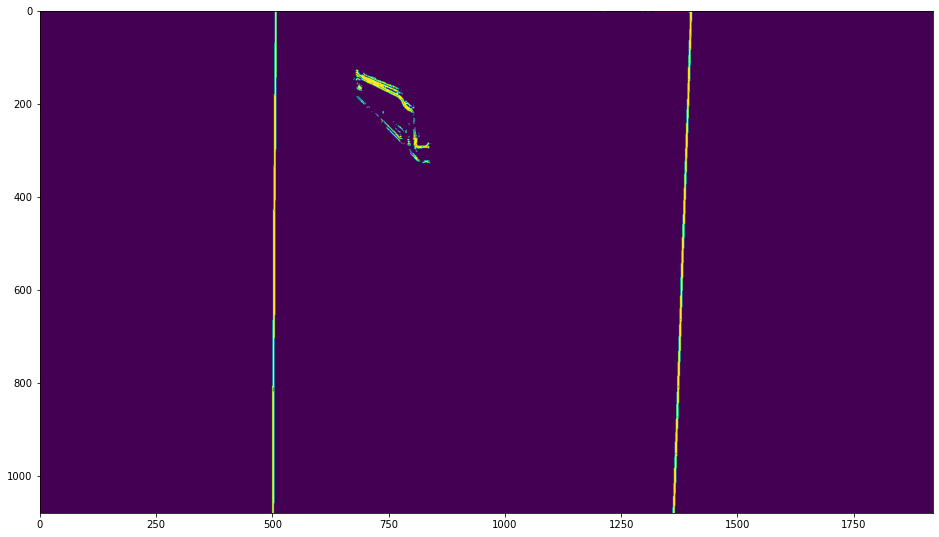

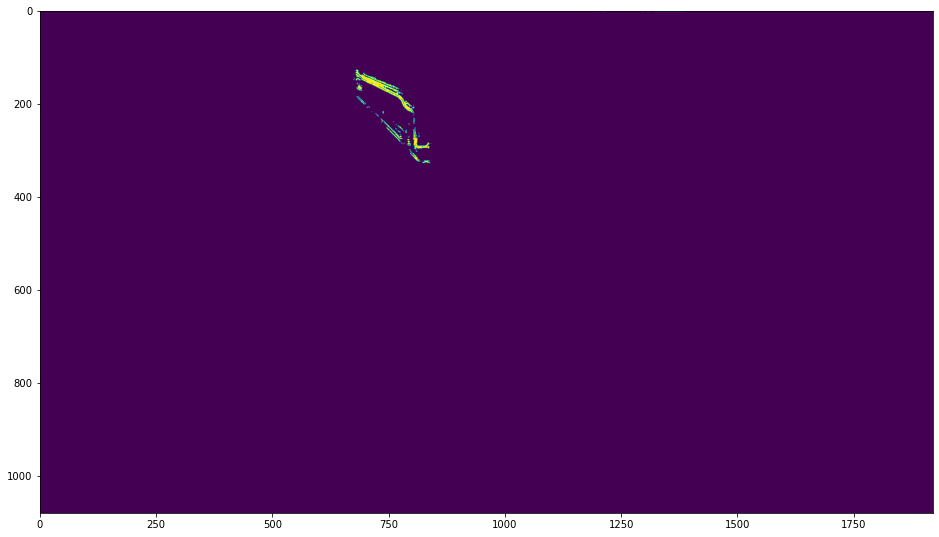

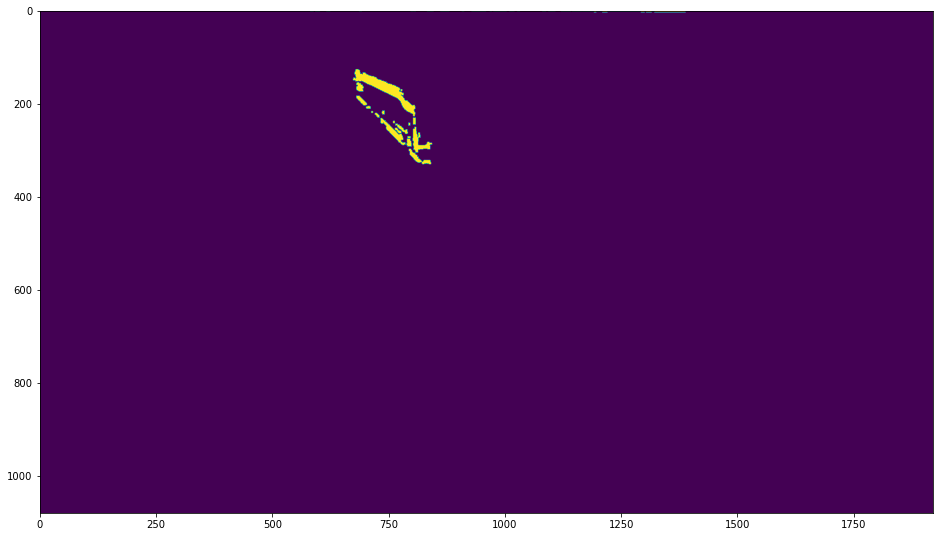

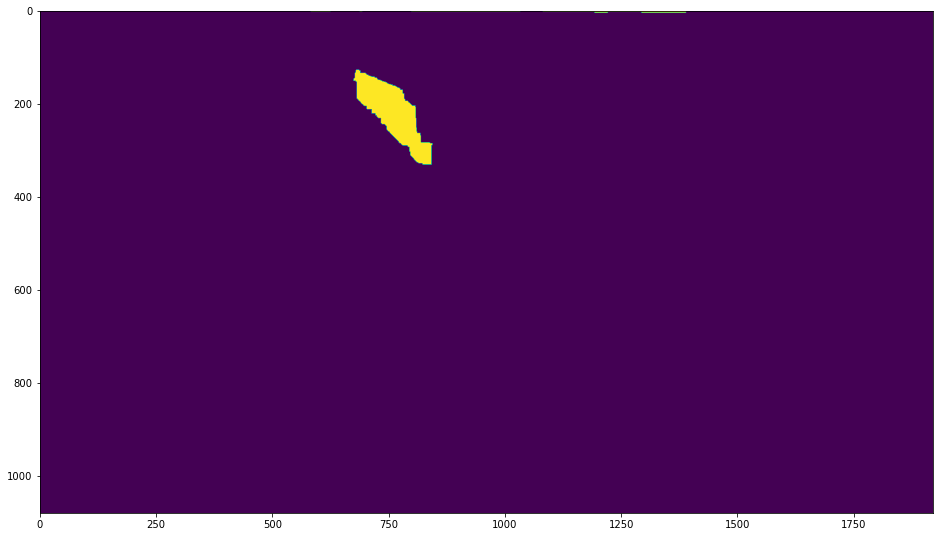

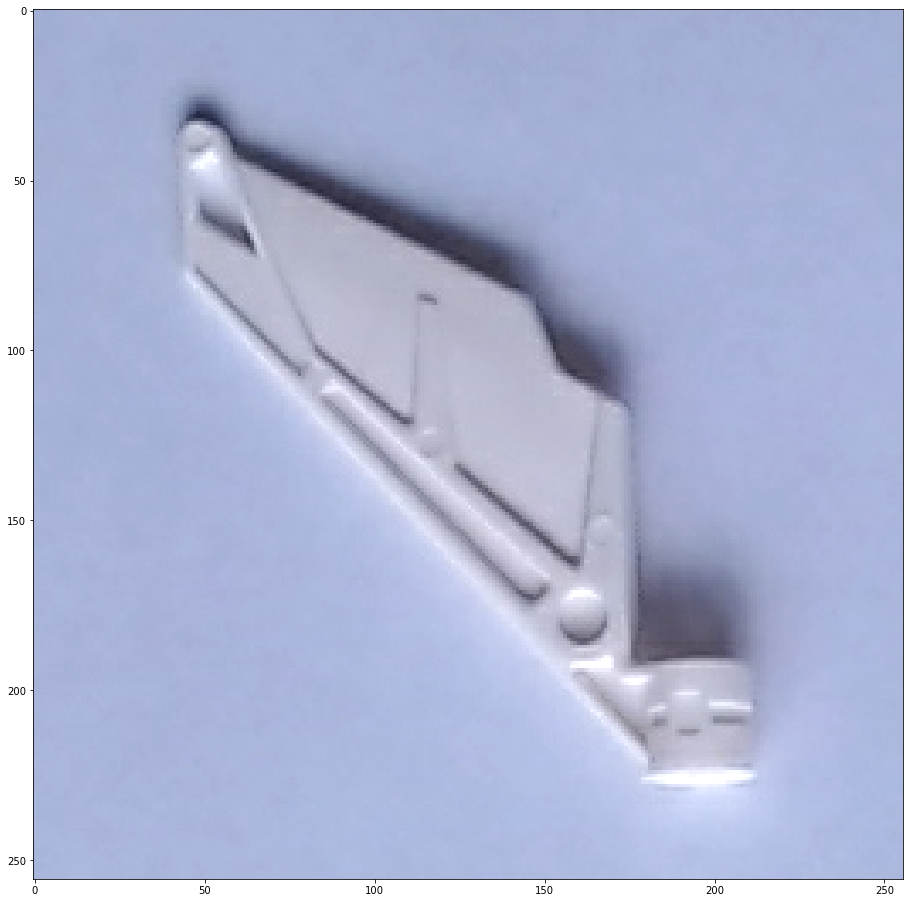

In [87]:
test_image(IMAGE_PATH)

In [88]:
#fdfdfdfdfds = "fdffd

In [89]:
import json
import os

In [90]:
PATH_CROP="../data/crop"
DATA_JSON_PATH = "../data/description/data.json"
DATA_WITH_CROPS_JSON_PATH="../data/description/data_with_crops.json"

In [91]:
with open(DATA_JSON_PATH, "r") as f:
  data = json.load(f)

data

{'captures': [{'id': '6323476',
   'name': 'wing_big',
   'image_path': '../data/images/1_6323476_wing_big.png',
   'additional_info': ''},
  {'id': '6323476',
   'name': 'wing_big',
   'image_path': '../data/images/2_6323476_wing_big.png',
   'additional_info': ''},
  {'id': '6323476',
   'name': 'wing_big',
   'image_path': '../data/images/3_6323476_wing_big.png',
   'additional_info': ''},
  {'id': '6323476',
   'name': 'wing_big',
   'image_path': '../data/images/4_6323476_wing_big.png',
   'additional_info': ''},
  {'id': '6323476',
   'name': 'wing_big',
   'image_path': '../data/images/5_6323476_wing_big.png',
   'additional_info': ''},
  {'id': '6323476',
   'name': 'wing_big',
   'image_path': '../data/images/6_6323476_wing_big.png',
   'additional_info': ''},
  {'id': '6323476',
   'name': 'wing_big',
   'image_path': '../data/images/7_6323476_wing_big.png',
   'additional_info': ''},
  {'id': '6323476',
   'name': 'wing_big',
   'image_path': '../data/images/8_6323476_wing_b

In [92]:
captures = [capture for capture in data["captures"] if capture["id"] not in {"0", "1"}]

In [93]:
unique_ids = set([capture["id"] for capture in captures])
unique_ids_dict = dict(zip(unique_ids, range(0, len(unique_ids))))
unique_ids_dict

{'6329156': 0,
 '6285534': 1,
 '6224075': 2,
 '6055123': 3,
 '6056830': 4,
 '6130009': 5,
 '6323476': 6,
 '300224': 7,
 '4243819': 8,
 '6271584': 9}

In [94]:
def process_capture(capture):
  capture_with_new_data = copy(capture)
  capture_with_new_data["numerated_id"] = unique_ids_dict[capture["id"]]

  image_path = capture["image_path"]
  image = load_image(image_path)
  crop = get_objects_mask(image, do_plot=False)
  cropped_to_save = cv2.cvtColor(crop, cv2.COLOR_RGB2BGR)

  cropped_name = f"crop_{os.path.basename(image_path)}"
  path_cropped = os.path.join(PATH_CROP, cropped_name)
  cv2.imwrite(path_cropped, cropped_to_save)
  capture_with_new_data["crop_path"] = path_cropped
  return capture_with_new_data

In [95]:
def process_captures(captures):
  captures_with_new_data = []
  for capture in captures:
    try:
      captures_with_new_data.append(process_capture(capture))
    except AssertionError:
      print(f"Failed on {capture}")

  return captures_with_new_data

In [96]:
captures_with_new_data = process_captures(captures)

Failed on {'id': '6323476', 'name': 'wing_big', 'image_path': '../data/images/9_6323476_wing_big.png', 'additional_info': ''}
Failed on {'id': '6323476', 'name': 'wing_big', 'image_path': '../data/images/13_6323476_wing_big.png', 'additional_info': ''}
Failed on {'id': '6323476', 'name': 'wing_big', 'image_path': '../data/images/19_6323476_wing_big.png', 'additional_info': ''}
Failed on {'id': '6323476', 'name': 'wing_big', 'image_path': '../data/images/25_6323476_wing_big.png', 'additional_info': ''}
Failed on {'id': '6323476', 'name': 'wing_big', 'image_path': '../data/images/28_6323476_wing_big.png', 'additional_info': ''}
Failed on {'id': '6323476', 'name': 'wing_big', 'image_path': '../data/images/36_6323476_wing_big.png', 'additional_info': ''}
Failed on {'id': '6323476', 'name': 'wing_big', 'image_path': '../data/images/37_6323476_wing_big.png', 'additional_info': ''}
Failed on {'id': '6323476', 'name': 'wing_big', 'image_path': '../data/images/41_6323476_wing_big.png', 'additio

In [99]:
new_data = {
  "numerated_ids": unique_ids_dict,
  "captures": captures_with_new_data
}

In [100]:
new_data

{'numerated_ids': {'6329156': 0,
  '6285534': 1,
  '6224075': 2,
  '6055123': 3,
  '6056830': 4,
  '6130009': 5,
  '6323476': 6,
  '300224': 7,
  '4243819': 8,
  '6271584': 9},
 'captures': [{'id': '6323476',
   'name': 'wing_big',
   'image_path': '../data/images/1_6323476_wing_big.png',
   'additional_info': '',
   'numerated_id': 6,
   'crop_path': '../data/crop/crop_1_6323476_wing_big.png'},
  {'id': '6323476',
   'name': 'wing_big',
   'image_path': '../data/images/2_6323476_wing_big.png',
   'additional_info': '',
   'numerated_id': 6,
   'crop_path': '../data/crop/crop_2_6323476_wing_big.png'},
  {'id': '6323476',
   'name': 'wing_big',
   'image_path': '../data/images/3_6323476_wing_big.png',
   'additional_info': '',
   'numerated_id': 6,
   'crop_path': '../data/crop/crop_3_6323476_wing_big.png'},
  {'id': '6323476',
   'name': 'wing_big',
   'image_path': '../data/images/4_6323476_wing_big.png',
   'additional_info': '',
   'numerated_id': 6,
   'crop_path': '../data/crop/cr

In [102]:
with open(DATA_WITH_CROPS_JSON_PATH, 'w') as file:
    json.dump(new_data, file, indent=4)